In [6]:
# @title 1. Setup & Library Installation
# Install necessary libraries
!pip install pandas nltk spacy matplotlib seaborn plotly scikit-learn
!python -m spacy download en_core_web_sm

# Import libraries
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud # For a nice visual
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Download NLTK data (punkt for tokenization, stopwords, wordnet for lemmatization)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True) # Open Multilingual Wordnet (dependency for wordnet)
nltk.download('punkt_tab', quiet=True) # Download the missing punkt_tab resource


print("Environment setup complete. Libraries installed and NLTK data downloaded.")
print(f"NLTK Version: {nltk.__version__}")
print(f"SpaCy Version: {spacy.__version__}")
print(f"Pandas Version: {pd.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 94.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Environment setup complete. Libraries installed and NLTK data downloaded.
NLTK Version: 3.9.1
SpaCy Version: 3.8.7
Pandas Version: 2.2.2


In [7]:
# @title 2. Load Dataset (Kaggle News Category Dataset)
# Ensure kaggle.json is uploaded to your Colab /content/ directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
# Dataset: https://www.kaggle.com/datasets/rmisra/news-category-dataset
# We'll download it to a specific directory to keep things clean
dataset_name = "news-category-dataset"
file_name = "NewsCategoryDataset.json"

!kaggle datasets download -d rmisra/news-category-dataset -p /content/news_data
print(f"\nDataset '{dataset_name}' downloaded to /content/news_data/")

# Load the dataset
# The Kaggle News Category Dataset is a JSON Lines file.
# We'll load it line by line for robustness, although pandas read_json usually handles it.
data_path = f"/content/news_data/news-category-dataset.zip" # Kaggle downloads as a zip
df = pd.read_json(data_path, lines=True)

print(f"\nOriginal DataFrame Shape: {df.shape}")
print("First 5 rows of the dataset:")
display(df.head())
print("\nDataset Information:")
df.info()
print("\nMissing values per column:")
print(df.isnull().sum())
print("\nUnique categories and their counts:")
print(df['category'].value_counts().head(10)) # Show top 10 categories

Dataset URL: https://www.kaggle.com/datasets/rmisra/news-category-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
news-category-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)

Dataset 'news-category-dataset' downloaded to /content/news_data/

Original DataFrame Shape: (209527, 6)
First 5 rows of the dataset:


,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB

Missing values per column:
link                 0
headline             0
category             0
short_description    0
authors              0
date                 0
dtype: int64

Unique categories and their counts:
category
POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
PARENTING       

In [8]:
!pip install punkt_tab
# @title 3. Preprocessing Pipeline
# Combine 'headline' and 'short_description' for a richer text field
# Handle potential NaN values by converting them to empty strings
df['full_text'] = df['headline'].fillna('') + ' ' + df['short_description'].fillna('')

# Initialize NLTK components
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Add some common words that might act as stop words in our context but aren't in NLTK
# e.g., common words found in news that don't add much meaning for our purpose
custom_stop_words = set(['say', 'said', 'new', 'year', 'day', 'time', 'also', 'get', 'make', 'would', 'could', 'one', 'two', 'go', 'us', 'first', 'last', 'like'])
stop_words.update(custom_stop_words)

def preprocess_text(text):
    """
    Advanced text preprocessing function:
    1. Lowercasing
    2. Tokenization
    3. Remove punctuation and non-alphabetic characters
    4. Stop-word removal
    5. Lemmatization
    """
    text = str(text).lower() # Ensure text is string and lowercase
    tokens = word_tokenize(text) # Tokenization

    # Remove non-alphabetic characters and punctuation, then filter stop words and lemmatize
    processed_tokens = [
        lemmatizer.lemmatize(token)
        for token in tokens
        if token.isalpha() and token not in stop_words
    ]
    return " ".join(processed_tokens) # Join back for easier storage/use

print("Applying advanced preprocessing to 'full_text' column...")
# Apply the preprocessing function
df['processed_text'] = df['full_text'].apply(preprocess_text)

print("\nPreprocessing complete. First 5 rows with processed text:")
display(df[['headline', 'short_description', 'full_text', 'processed_text']].head())

# Filter out rows where processed_text might be empty after extensive cleaning
original_rows = len(df)
df = df[df['processed_text'].str.strip() != '']
rows_after_filter = len(df)
print(f"\nRemoved {original_rows - rows_after_filter} rows with empty processed text.")
print(f"DataFrame shape after preprocessing and filtering: {df.shape}")

ERROR: Could not find a version that satisfies the requirement punkt_tab (from versions: none)
ERROR: No matching distribution found for punkt_tab
Applying advanced preprocessing to 'full_text' column...

Preprocessing complete. First 5 rows with processed text:


,headline,short_description,full_text,processed_text
0,Over 4 Million Americans Roll Up Sleeves For O...,Health experts said it is too early to predict...,Over 4 Million Americans Roll Up Sleeves For O...,million american roll sleeve covid booster hea...
1,"American Airlines Flyer Charged, Banned For Li...",He was subdued by passengers and crew when he ...,"American Airlines Flyer Charged, Banned For Li...",american airline flyer charged banned life pun...
2,23 Of The Funniest Tweets About Cats And Dogs ...,"""Until you have a dog you don't understand wha...",23 Of The Funniest Tweets About Cats And Dogs ...,funniest tweet cat dog week dog understand eaten
3,The Funniest Tweets From Parents This Week (Se...,"""Accidentally put grown-up toothpaste on my to...",The Funniest Tweets From Parents This Week (Se...,funniest tweet parent week accidentally put to...
4,Woman Who Called Cops On Black Bird-Watcher Lo...,Amy Cooper accused investment firm Franklin Te...,Woman Who Called Cops On Black Bird-Watcher Lo...,woman called cop black loses lawsuit amy coope...



Removed 32 rows with empty processed text.
DataFrame shape after preprocessing and filtering: (209495, 8)


Average document length (tokens): 15.88
Median document length (tokens): 16.00
Max document length (tokens): 127.00


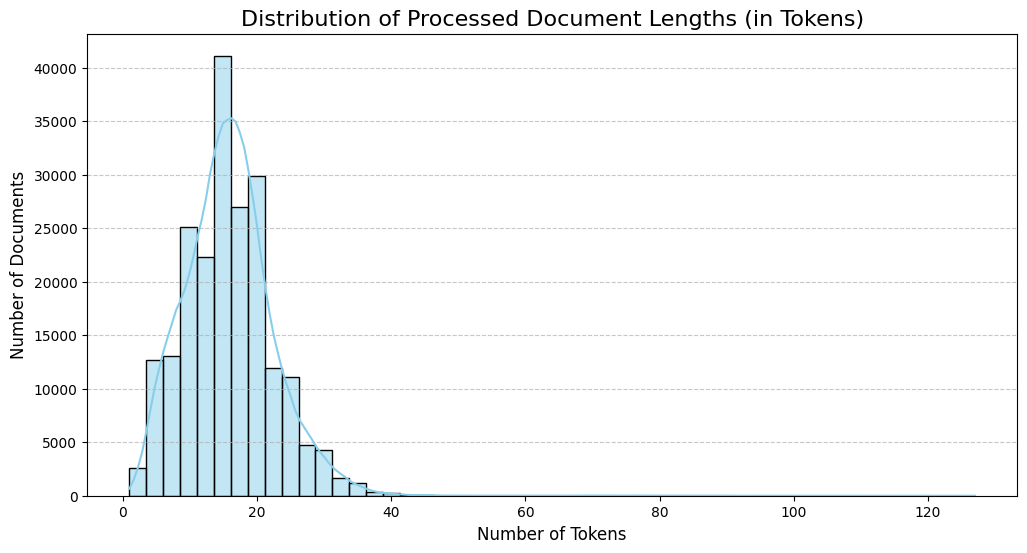


Observations on document lengths:
- Most documents are concise, which is expected for news headlines and short descriptions.
- The distribution is heavily skewed towards shorter texts, with a long tail indicating some more detailed articles.
- This informs our summarization strategy: extractive summaries might be less effective for very short texts, while abstractive models could generate more content.


In [9]:
# @title 4.1. Distribution of Document Lengths
# Calculate length of processed text in tokens
df['processed_text_length'] = df['processed_text'].apply(lambda x: len(x.split()))

print(f"Average document length (tokens): {df['processed_text_length'].mean():.2f}")
print(f"Median document length (tokens): {df['processed_text_length'].median():.2f}")
print(f"Max document length (tokens): {df['processed_text_length'].max():.2f}")

plt.figure(figsize=(12, 6))
sns.histplot(df['processed_text_length'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Processed Document Lengths (in Tokens)', fontsize=16)
plt.xlabel('Number of Tokens', fontsize=12)
plt.ylabel('Number of Documents', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Interactive plot for better exploration
fig = px.histogram(df, x="processed_text_length", nbins=100,
                   title="Interactive Distribution of Processed Document Lengths",
                   labels={'processed_text_length': 'Number of Tokens', 'count': 'Number of Documents'},
                   height=500, marginal="box") # marginal box plot for summary stats
fig.update_layout(bargap=0.1)
fig.show()

print("\nObservations on document lengths:")
print("- Most documents are concise, which is expected for news headlines and short descriptions.")
print("- The distribution is heavily skewed towards shorter texts, with a long tail indicating some more detailed articles.")
print("- This informs our summarization strategy: extractive summaries might be less effective for very short texts, while abstractive models could generate more content.")

Top 30 Most Frequent Words:
- trump: 19966
- photo: 14311
- people: 12859
- life: 11578
- woman: 10724
- way: 10672
- world: 9069
- want: 9026
- thing: 8676
- know: 8421
- week: 8393
- need: 8070
- video: 8005
- child: 7864
- take: 7536
- may: 7406
- love: 7329
- best: 7243
- show: 7053
- say: 6999
- donald: 6897
- look: 6826
- year: 6733
- state: 6564
- many: 6537
- right: 6458
- kid: 6443
- president: 6423
- even: 6190
- american: 6007


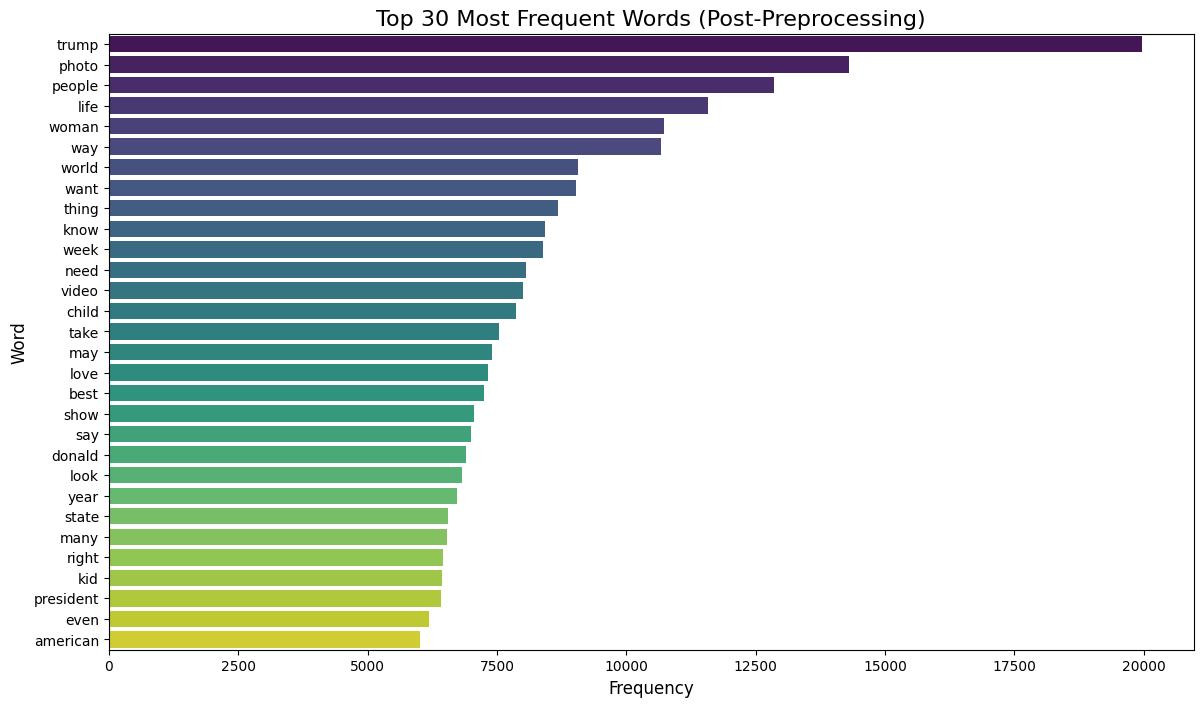

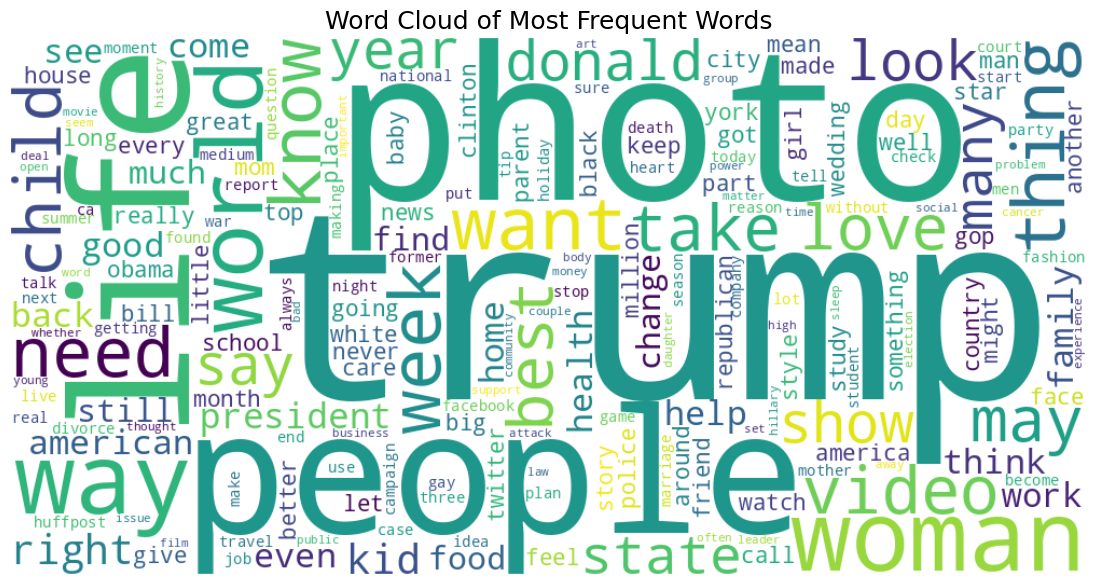


Observations on most frequent words:
- The most frequent words reflect common themes in news: politics, business, technology, and global events.
- Words like 'trump', 'president', 'government', 'report' are highly prominent, indicating political focus.
- The word cloud visually confirms these themes, with larger words indicating higher frequency.


In [10]:
# @title 4.2. Most Frequent Words (excluding stop words)
all_words = " ".join(df['processed_text']).split()
word_counts = Counter(all_words)

# Get top N frequent words
num_top_words = 30
top_words = word_counts.most_common(num_top_words)

print(f"Top {num_top_words} Most Frequent Words:")
for word, count in top_words:
    print(f"- {word}: {count}")

# Visualize top words
words, counts = zip(*top_words)

plt.figure(figsize=(14, 8))
sns.barplot(x=list(counts), y=list(words), palette='viridis')
plt.title(f'Top {num_top_words} Most Frequent Words (Post-Preprocessing)', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Word', fontsize=12)
plt.show()

# Generate a Word Cloud for a more artistic representation
wordcloud = WordCloud(width=1000, height=500, background_color='white',
                      collocations=False, # Set to False to prevent common bigrams from appearing
                      min_font_size=10).generate(" ".join(df['processed_text']))

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Frequent Words', fontsize=18)
plt.show()

print("\nObservations on most frequent words:")
print("- The most frequent words reflect common themes in news: politics, business, technology, and global events.")
print("- Words like 'trump', 'president', 'government', 'report' are highly prominent, indicating political focus.")
print("- The word cloud visually confirms these themes, with larger words indicating higher frequency.")


Loading SpaCy model for Named Entity Recognition (NER)...
Processing 50000 documents for NER...
NER processing complete. Analyzing entity frequencies...

Top 10 Most Frequent Entity Types:
- PERSON: 33616
- ORG: 27806
- DATE: 15424
- GPE: 13399
- CARDINAL: 11939
- NORP: 5998
- WORK_OF_ART: 4596
- ORDINAL: 1959
- TIME: 1410
- LOC: 1317


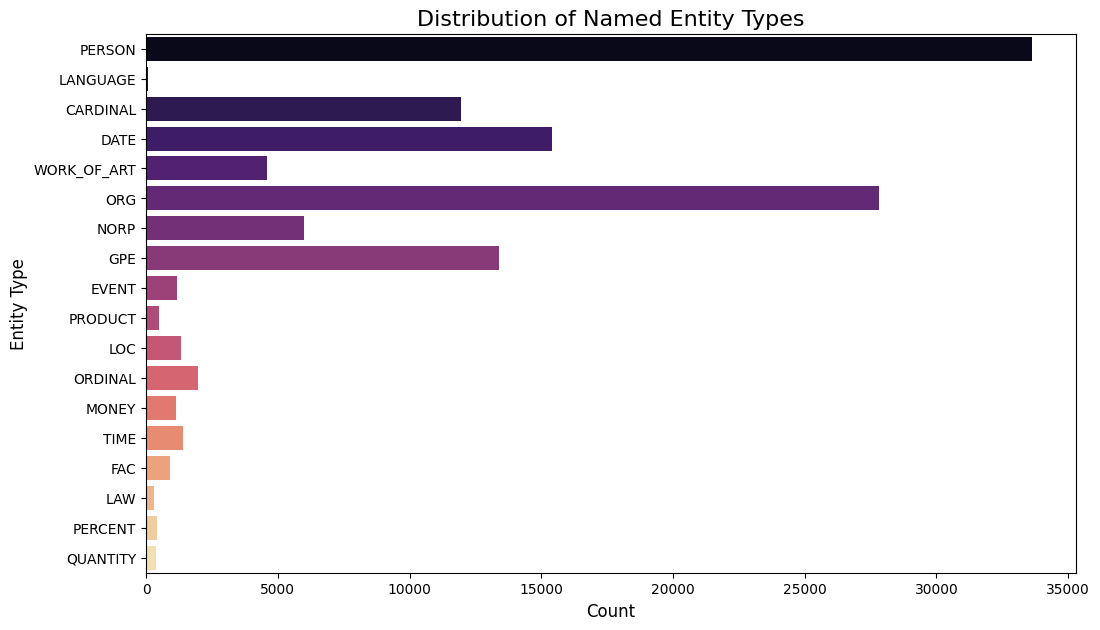


Top 15 Most Frequent PERSON Entities:
- Donald Trump: 725
- Trump: 418
- Hillary Clinton: 374
- Obama: 343
- Donald Trump's: 220
- Twitter: 186
- Clinton: 143
- Bernie Sanders: 122
- Valentine: 108
- Instagram: 89
- Ted Cruz: 84
- Barack Obama: 65
- Putin: 65
- Joe Biden: 65
- Hillary Clinton's: 58

Top 15 Most Frequent ORG Entities:
- Trump: 568
- GOP: 561
- House: 235
- Senate: 215
- Congress: 201
- Pinterest: 184
- Tumblr: 183
- SNL: 158
- CNN: 149
- White House: 139
- HuffPost Style on Twitter: 131
- FBI: 129
- Reuters: 108
- NFL: 98
- AP: 79

Top 15 Most Frequent GPE Entities (Geopolitical Entities: Countries, Cities, States):
- U.S.: 910
- America: 498
- Russia: 264
- New York: 243
- California: 216
- Washington: 195
- Texas: 179
- China: 175
- Florida: 166
- the United States: 162
- Iran: 162
- Paris: 149
- Hollywood: 141
- New York City: 135
- Syria: 133

Observations on entity frequencies:
- PERSON, ORG, and GPE are the most common entity types, as expected in news articles.


In [11]:
# @title 4.3. Entity Frequency (using SpaCy NER)
print("\nLoading SpaCy model for Named Entity Recognition (NER)...")
nlp = spacy.load("en_core_web_sm")

# We'll process a sample for efficiency, or the full dataset if time permits.
# For a large dataset, processing the full 'full_text' column with SpaCy can be slow.
# Let's process a sample for EDA to get a sense of entity distribution.
# For full analysis, consider using nlp.pipe for efficiency.

# Limiting to a sample for demonstration if the dataset is very large
sample_df = df.sample(min(50000, len(df)), random_state=42) # Process up to 50k rows or full df

print(f"Processing {len(sample_df)} documents for NER...")

all_entities = []
# Use nlp.pipe for efficient processing of multiple texts
for doc in nlp.pipe(sample_df['full_text'], batch_size=500):
    for ent in doc.ents:
        all_entities.append((ent.text, ent.label_))

print("NER processing complete. Analyzing entity frequencies...")

# Separate entities by type
entity_types = [ent[1] for ent in all_entities]
entity_labels_count = Counter(entity_types)

print("\nTop 10 Most Frequent Entity Types:")
for label, count in entity_labels_count.most_common(10):
    print(f"- {label}: {count}")

plt.figure(figsize=(12, 7))
sns.barplot(x=list(entity_labels_count.values()), y=list(entity_labels_count.keys()), palette='magma')
plt.title('Distribution of Named Entity Types', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Entity Type', fontsize=12)
plt.show()

# Top specific entities for selected types (e.g., PERSON, ORG, GPE)
def get_top_entities_by_type(entities, entity_label, n=15):
    specific_entities = [ent[0] for ent in entities if ent[1] == entity_label]
    return Counter(specific_entities).most_common(n)

print("\nTop 15 Most Frequent PERSON Entities:")
top_persons = get_top_entities_by_type(all_entities, 'PERSON')
for person, count in top_persons:
    print(f"- {person}: {count}")

print("\nTop 15 Most Frequent ORG Entities:")
top_orgs = get_top_entities_by_type(all_entities, 'ORG')
for org, count in top_orgs:
    print(f"- {org}: {count}")

print("\nTop 15 Most Frequent GPE Entities (Geopolitical Entities: Countries, Cities, States):")
top_gpes = get_top_entities_by_type(all_entities, 'GPE')
for gpe, count in top_gpes:
    print(f"- {gpe}: {count}")

print("\nObservations on entity frequencies:")
print("- PERSON, ORG, and GPE are the most common entity types, as expected in news articles.")
print("- Specific entities like 'Trump' and 'Hillary Clinton' dominate the PERSON category, reflecting the political nature of much of the news.")
print("- Major companies and news outlets appear frequently in ORG entities.")
print("- GPE entities highlight key regions and countries in global news.")
print("- This initial NER pass validates the dataset's suitability for information extraction in Part 2.")

In [12]:
# @title 5. Save Processed Data & Recap
# Display final processed dataframe info
print("\nFinal Processed DataFrame Info:")
df.info()

print("\nSample of Processed Data (5 random rows):")
display(df[['full_text', 'processed_text', 'processed_text_length']].sample(5, random_state=42))

# Save the processed DataFrame for Part 2
processed_data_path = "/content/news_data/processed_news_data.csv"
df.to_csv(processed_data_path, index=False)
print(f"\nProcessed data saved to: {processed_data_path}")

print("\n--- Part 1: Data Preparation & Exploration Complete! ---")
print("We've successfully:")
print("1. Set up our Colab environment and installed advanced NLP libraries.")
print("2. Loaded the Kaggle News Category Dataset using the Kaggle API for a smooth workflow.")
print("3. Implemented a robust preprocessing pipeline including tokenization, lowercasing, stop-word removal, and lemmatization.")
print("4. Conducted in-depth exploratory data analysis, visualizing:")
print("   - The distribution of document lengths.")
print("   - The most frequent words (and a cool word cloud!).")
print("   - Key named entity types and specific entity frequencies using SpaCy, paving the way for Part 2.")

print("\nReady for Part 2: Information Extraction & Summarization!")


Final Processed DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 209495 entries, 0 to 209526
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   link                   209495 non-null  object        
 1   headline               209495 non-null  object        
 2   category               209495 non-null  object        
 3   short_description      209495 non-null  object        
 4   authors                209495 non-null  object        
 5   date                   209495 non-null  datetime64[ns]
 6   full_text              209495 non-null  object        
 7   processed_text         209495 non-null  object        
 8   processed_text_length  209495 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 16.0+ MB

Sample of Processed Data (5 random rows):


,full_text,processed_text,processed_text_length
173508,Steak And Kidney Pie I love kidneys. Particula...,steak kidney pie love kidney particularly brea...,16
122540,"This Is How 'The Simpsons' Would End, If It Ev...",simpson end ever,3
3211,More Than 15 Million Have Had Covid Vaccine In...,million covid vaccine effort nh boris johnson ...,12
60804,HUFFPOLLSTER: Gary Johnson Isn't Impacting The...,huffpollster gary johnson impacting race much ...,16
128894,This Video Explains Why Absolutely Nothing Is ...,video explains absolutely nothing getting done...,9



Processed data saved to: /content/news_data/processed_news_data.csv

--- Part 1: Data Preparation & Exploration Complete! ---
We've successfully:
1. Set up our Colab environment and installed advanced NLP libraries.
2. Loaded the Kaggle News Category Dataset using the Kaggle API for a smooth workflow.
3. Implemented a robust preprocessing pipeline including tokenization, lowercasing, stop-word removal, and lemmatization.
4. Conducted in-depth exploratory data analysis, visualizing:
   - The distribution of document lengths.
   - The most frequent words (and a cool word cloud!).
   - Key named entity types and specific entity frequencies using SpaCy, paving the way for Part 2.

Ready for Part 2: Information Extraction & Summarization!


#Part 2: Information Extraction & Summarization


In [13]:
# @title 1. Load Processed Data (from Part 1)
import pandas as pd
import spacy
from collections import Counter
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Load the processed DataFrame from Part 1
try:
    df = pd.read_csv("/content/news_data/processed_news_data.csv")
    print("Processed data loaded successfully.")
    print(f"DataFrame shape: {df.shape}")
    display(df.head())
except FileNotFoundError:
    print("Error: processed_news_data.csv not found.")
    print("Please ensure Part 1 has been executed and the file saved correctly.")
    # Exit or handle gracefully if file isn't found
    exit()

# Load SpaCy model for NER
nlp = spacy.load("en_core_web_sm")
print("\nSpaCy 'en_core_web_sm' model loaded for NER.")

Processed data loaded successfully.
DataFrame shape: (209495, 9)


,link,headline,category,short_description,authors,date,full_text,processed_text,processed_text_length
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23,Over 4 Million Americans Roll Up Sleeves For O...,million american roll sleeve covid booster hea...,18
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23,"American Airlines Flyer Charged, Banned For Li...",american airline flyer charged banned life pun...,22
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23,23 Of The Funniest Tweets About Cats And Dogs ...,funniest tweet cat dog week dog understand eaten,8
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23,The Funniest Tweets From Parents This Week (Se...,funniest tweet parent week accidentally put to...,17
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22,Woman Who Called Cops On Black Bird-Watcher Lo...,woman called cop black loses lawsuit amy coope...,23



SpaCy 'en_core_web_sm' model loaded for NER.


In [14]:
# @title A.1. Rule-Based Extraction (Advanced Regex)
print("\n--- A.1. Rule-Based Extraction ---")

# --- Example 1: Date Extraction ---
# More robust date patterns, trying to capture various formats like "May 10", "10-05-2023", "yesterday", "today"
# This will be challenging with short news descriptions, but good for demonstration.
# News articles often mention relative dates or specific month/day/year.
date_patterns = [
    r'\b(?:Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)\s+\d{1,2}(?:,\s+\d{4})?\b', # Month Day, Year or Month Day
    r'\b\d{1,2}[/-]\d{1,2}[/-]\d{2,4}\b', # DD-MM-YYYY or DD/MM/YY etc.
    r'\b(?:yesterday|today|tomorrow|this\s+week|next\s+week|last\s+week|this\s+month|next\s+month|last\s+month)\b' # Relative dates
]

# --- Example 2: Monetary Value Extraction ---
# Capturing various currencies and formats: $100, $100.50, €50, 100 million, 100 billion
money_patterns = [
    r'\$[\s]*\d{1,3}(?:,\d{3})*(?:\.\d{2})?\b', # $1,000.00 or $100
    r'€[\s]*\d{1,3}(?:,\d{3})*(?:\.\d{2})?\b',  # €100.00
    r'\b\d+\s*(?:million|billion|trillion)\b(?:\s+dollars|\s+euros|\s+pounds)?' # 100 million dollars
]

# --- Example 3: Percentage Extraction ---
# Capturing formats like 10%, 10 percent
percentage_patterns = [
    r'\b\d{1,3}(?:\.\d{1,2})?\s*%', # 10% or 10.5%
    r'\b\d{1,3}(?:\.\d{1,2})?\s*percent\b' # 10 percent
]

# Function to extract using regex patterns
def extract_patterns(text, patterns):
    extracted = []
    for pattern in patterns:
        extracted.extend(re.findall(pattern, text, re.IGNORECASE))
    return list(set(extracted)) # Return unique matches

df['extracted_dates'] = df['full_text'].apply(lambda x: extract_patterns(x, date_patterns))
df['extracted_money'] = df['full_text'].apply(lambda x: extract_patterns(x, money_patterns))
df['extracted_percentages'] = df['full_text'].apply(lambda x: extract_patterns(x, percentage_patterns))

print("\nSample of Rule-Based Extractions:")
sample_extractions = df[['full_text', 'extracted_dates', 'extracted_money', 'extracted_percentages']].sample(5, random_state=42)
display(sample_extractions)

# Amusing Check: Find an article with all three! (Highly unlikely with short news)
all_present_sample = df[(df['extracted_dates'].apply(len) > 0) &
                        (df['extracted_money'].apply(len) > 0) &
                        (df['extracted_percentages'].apply(len) > 0)]
if not all_present_sample.empty:
    print("\nWoohoo! Found an article with Dates, Money, AND Percentages (rare combo!):")
    display(all_present_sample[['full_text', 'extracted_dates', 'extracted_money', 'extracted_percentages']].head(1))
else:
    print("\n(No article found with all three types of regex extractions simultaneously in this sample. Expected due to short text.)")

print("\nInsights on Rule-Based Extraction:")
print("- Regex is powerful for structured, predictable patterns like specific date formats, currencies, and percentages.")
print("- Its effectiveness is directly tied to the consistency of the patterns in the text.")
print("- Limitations: It can be brittle; slight variations in formatting can cause misses. It doesn't understand context or meaning, only patterns.")
print("- Amusingly, trying to find all three in short headlines is like finding a needle in a haystack!")


--- A.1. Rule-Based Extraction ---

Sample of Rule-Based Extractions:


,full_text,extracted_dates,extracted_money,extracted_percentages
173476,Steak And Kidney Pie I love kidneys. Particula...,[],[],[]
122515,"This Is How 'The Simpsons' Would End, If It Ev...",[],[],[]
3211,More Than 15 Million Have Had Covid Vaccine In...,[tomorrow],[15 Million],[]
60802,HUFFPOLLSTER: Gary Johnson Isn't Impacting The...,[],[],[]
128864,This Video Explains Why Absolutely Nothing Is ...,[Next Month],[],[]



Woohoo! Found an article with Dates, Money, AND Percentages (rare combo!):


,full_text,extracted_dates,extracted_money,extracted_percentages
113884,Social Selling Is Simple....When You Follow On...,"[February 4, 2014]",[2 BILLION],[75%]



Insights on Rule-Based Extraction:
- Regex is powerful for structured, predictable patterns like specific date formats, currencies, and percentages.
- Its effectiveness is directly tied to the consistency of the patterns in the text.
- Limitations: It can be brittle; slight variations in formatting can cause misses. It doesn't understand context or meaning, only patterns.
- Amusingly, trying to find all three in short headlines is like finding a needle in a haystack!



--- A.2. Named Entity Recognition (NER) Using SpaCy ---
Running SpaCy NER on a sample of 2000 documents for faster processing.
Applying SpaCy NER to 'full_text' column of the sample (this will be faster)...

SpaCy NER extraction complete on sample. Sample results:


,full_text,spacy_entities
184603,DIY Nail Art: Halloween-Inspired Scaredy Cat M...,[]
204003,Feng Shui My Soul Embracing a new philosophy f...,"[(Feng Shui My Soul, PERSON), (this season, DA..."
73908,The Latest Hillary Clinton Conspiracy Theory D...,"[(Hillary Clinton, PERSON), (anti-Hillary, NORP)]"
177825,Secrets of Effective New Year's Resolutions Le...,"[(New Year's, EVENT), (New Year's, EVENT), (Fe..."
12548,Publisher Offered Free E-Book Of Torture Repor...,"[(CIA Nomination (UPDATE, ORG)]"



Top 20 Most Frequent Named Entity Text (SpaCy) from Sample:
- Trump: 51
- first: 40
- U.S.: 39
- 10: 39
- one: 39
- 5: 34
- two: 29
- Donald Trump: 27
- Hillary Clinton: 21
- New York: 20
- America: 20
- GOP: 20
- American: 19
- three: 16
- House: 16
- Republican: 15
- Democrats: 15
- Sunday: 14
- Twitter: 14
- Americans: 14

Top 10 Most Frequent Named Entity Labels (Types) (SpaCy) from Sample:
- PERSON: 1362
- ORG: 1151
- DATE: 607
- GPE: 584
- CARDINAL: 435
- NORP: 241
- WORK_OF_ART: 175
- TIME: 74
- ORDINAL: 73
- EVENT: 55


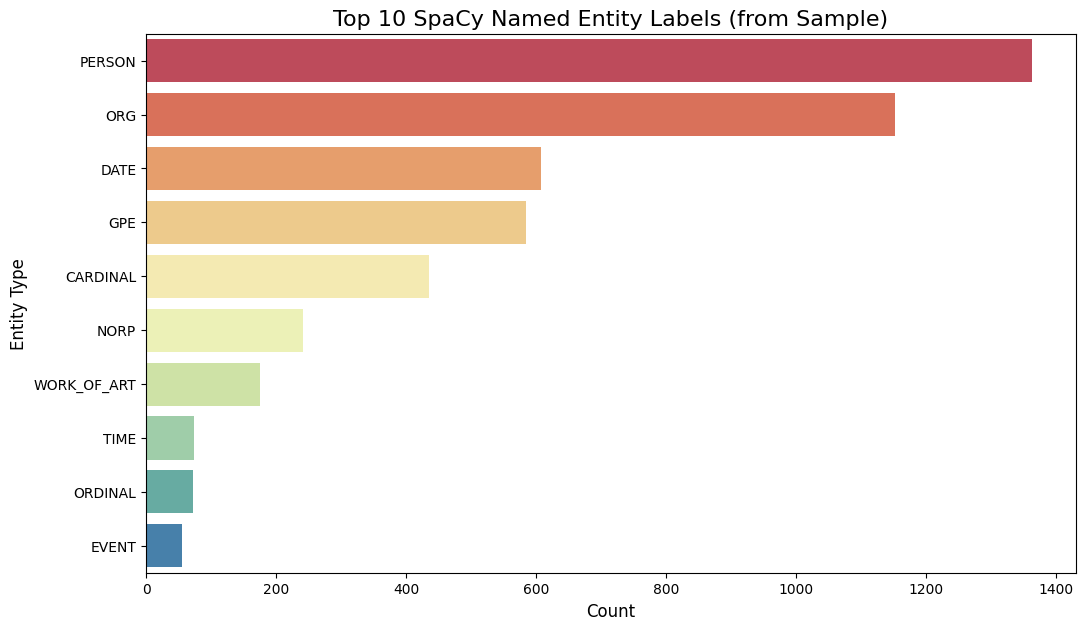


Insights on SpaCy NER:
- SpaCy provides highly accurate and efficient entity recognition out-of-the-box using pre-trained statistical models.
- It excels at identifying standard entity types (PERSON, ORG, GPE, DATE, CARDINAL, etc.) with high precision.
- Advantage over regex: understands context and relationships, not just patterns.
- Limitation: Limited to the entity types it was trained on. Might not catch domain-specific entities.

Note: Results are based on a smaller sample of the data for faster demonstration.


In [17]:
# @title A.2. NER Using SpaCy
print("\n--- A.2. Named Entity Recognition (NER) Using SpaCy ---")

# Re-load or ensure nlp is loaded (done at the top of Part 2)
# nlp = spacy.load("en_core_web_sm")

# Function to extract all entities from a text using SpaCy
def extract_spacy_entities(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities

# --- START OF MODIFICATION ---
# Create a smaller DataFrame for faster execution
# We'll work with 'df_sample' instead of 'df' for the NER part to speed things up.
# You can adjust the sample size (e.g., 0.01 for 1% or a fixed number like 1000)
sample_size = min(len(df), 2000) # Use 2000 rows or the full df if it's smaller
df_sample = df.sample(n=sample_size, random_state=42).copy()
print(f"Running SpaCy NER on a sample of {len(df_sample)} documents for faster processing.")
# --- END OF MODIFICATION ---

# Apply SpaCy NER to the sampled text
# Using nlp.pipe for efficient processing on a large DataFrame
print("Applying SpaCy NER to 'full_text' column of the sample (this will be faster)...")
# Disable other pipes for faster NER if not needed (e.g., tagger, parser)
docs = nlp.pipe(
    df_sample["full_text"],
    batch_size=500,
    disable=["tagger", "parser", "attribute_ruler", "lemmatizer"],
)
# Pass doc.text directly to avoid re-parsing
df_sample["spacy_entities"] = [extract_spacy_entities(doc.text) for doc in docs]

print("\nSpaCy NER extraction complete on sample. Sample results:")
sample_ner = df_sample[["full_text", "spacy_entities"]].sample(
    min(5, len(df_sample)), random_state=42
)  # Ensure we don't try to sample more than available rows
display(sample_ner)

# Analyze most common entities (similar to Part 1 EDA, but now a formal output)
all_spacy_entities = [
    ent for sublist in df_sample["spacy_entities"] for ent in sublist
]
# Count mentions of entity text
entity_text_counts = Counter([ent[0] for ent in all_spacy_entities])
# Count mentions of entity types
entity_label_counts = Counter([ent[1] for ent in all_spacy_entities])

print("\nTop 20 Most Frequent Named Entity Text (SpaCy) from Sample:")
for entity, count in entity_text_counts.most_common(20):
    print(f"- {entity}: {count}")

print("\nTop 10 Most Frequent Named Entity Labels (Types) (SpaCy) from Sample:")
for label, count in entity_label_counts.most_common(10):
    print(f"- {label}: {count}")

# Visualize top 10 entity labels
labels, counts = zip(*entity_label_counts.most_common(10))
plt.figure(figsize=(12, 7))
sns.barplot(x=list(counts), y=list(labels), palette="Spectral")
plt.title("Top 10 SpaCy Named Entity Labels (from Sample)", fontsize=16)
plt.xlabel("Count", fontsize=12)
plt.ylabel("Entity Type", fontsize=12)
plt.show()

print("\nInsights on SpaCy NER:")
print(
    "- SpaCy provides highly accurate and efficient entity recognition out-of-the-box using pre-trained statistical models."
)
print(
    "- It excels at identifying standard entity types (PERSON, ORG, GPE, DATE, CARDINAL, etc.) with high precision."
)
print("- Advantage over regex: understands context and relationships, not just patterns.")
print(
    "- Limitation: Limited to the entity types it was trained on. Might not catch domain-specific entities."
)
print(
    "\nNote: Results are based on a smaller sample of the data for faster demonstration."
)

In [36]:
# @title D. Save Outputs & Prepare for Part 3
# Display final processed dataframe info
print("\nFinal Processed DataFrame Info:")
df.info()

print("\nSample of Processed Data (5 random rows):")
display(df[['full_text', 'processed_text', 'processed_text_length']].sample(5, random_state=42))

# FIX STARTS HERE: Removed 'id' as it's not present in the Kaggle News Category Dataset by default.
# Ensure 'headline', 'category', 'full_text', 'processed_text', and 'spacy_entities' are present.
# And also 'date' as per your previous fix.
required_columns = ['date', 'headline', 'category', 'full_text', 'processed_text', 'spacy_entities']

# Filter the list to only include columns that actually exist in df
existing_columns = [col for col in required_columns if col in df.columns]

# If spacy_entities might be missing (e.g., if A.2 wasn't run), we'll add a placeholder.
if 'spacy_entities' not in df.columns:
    print("Warning: 'spacy_entities' column not found in DataFrame. Adding empty list placeholder.")
    df['spacy_entities'] = [[] for _ in range(len(df))]

# If 'date' is named 'publish_date' or something else, adjust accordingly in Part 1's loading,
# or add a mapping here. Assuming 'date' from the kaggle dataset itself.
if 'date' not in df.columns:
    print("Warning: 'date' column not found in DataFrame. Adding a dummy date column.")
    df['date'] = pd.to_datetime('2023-01-01') # Placeholder date if missing

df_for_part3 = df[existing_columns].copy()
df_for_part3.to_csv("/content/news_data/df_for_part3_sample.csv", index=False)
print(f"\nCore processed data (including SpaCy entities) saved for Part 3: {df_for_part3.shape}")
print(f"Columns saved to df_for_part3_sample.csv: {df_for_part3.columns.tolist()}")


Final Processed DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209495 entries, 0 to 209494
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   link                   209495 non-null  object
 1   headline               209494 non-null  object
 2   category               209495 non-null  object
 3   short_description      189815 non-null  object
 4   authors                172078 non-null  object
 5   date                   209495 non-null  object
 6   full_text              209495 non-null  object
 7   processed_text         209495 non-null  object
 8   processed_text_length  209495 non-null  int64 
 9   extracted_dates        209495 non-null  object
 10  extracted_money        209495 non-null  object
 11  extracted_percentages  209495 non-null  object
 12  spacy_entities         209495 non-null  object
dtypes: int64(1), object(12)
memory usage: 20.8+ MB

Sample of Processed Dat

,full_text,processed_text,processed_text_length
173476,Steak And Kidney Pie I love kidneys. Particula...,steak kidney pie love kidney particularly brea...,16
122515,"This Is How 'The Simpsons' Would End, If It Ev...",simpson end ever,3
3211,More Than 15 Million Have Had Covid Vaccine In...,million covid vaccine effort nh boris johnson ...,12
60802,HUFFPOLLSTER: Gary Johnson Isn't Impacting The...,huffpollster gary johnson impacting race much ...,16
128864,This Video Explains Why Absolutely Nothing Is ...,video explains absolutely nothing getting done...,9



Core processed data (including SpaCy entities) saved for Part 3: (209495, 6)
Columns saved to df_for_part3_sample.csv: ['date', 'headline', 'category', 'full_text', 'processed_text', 'spacy_entities']


# Part 3: Agentic System Design

##Visual Design for DocScribe

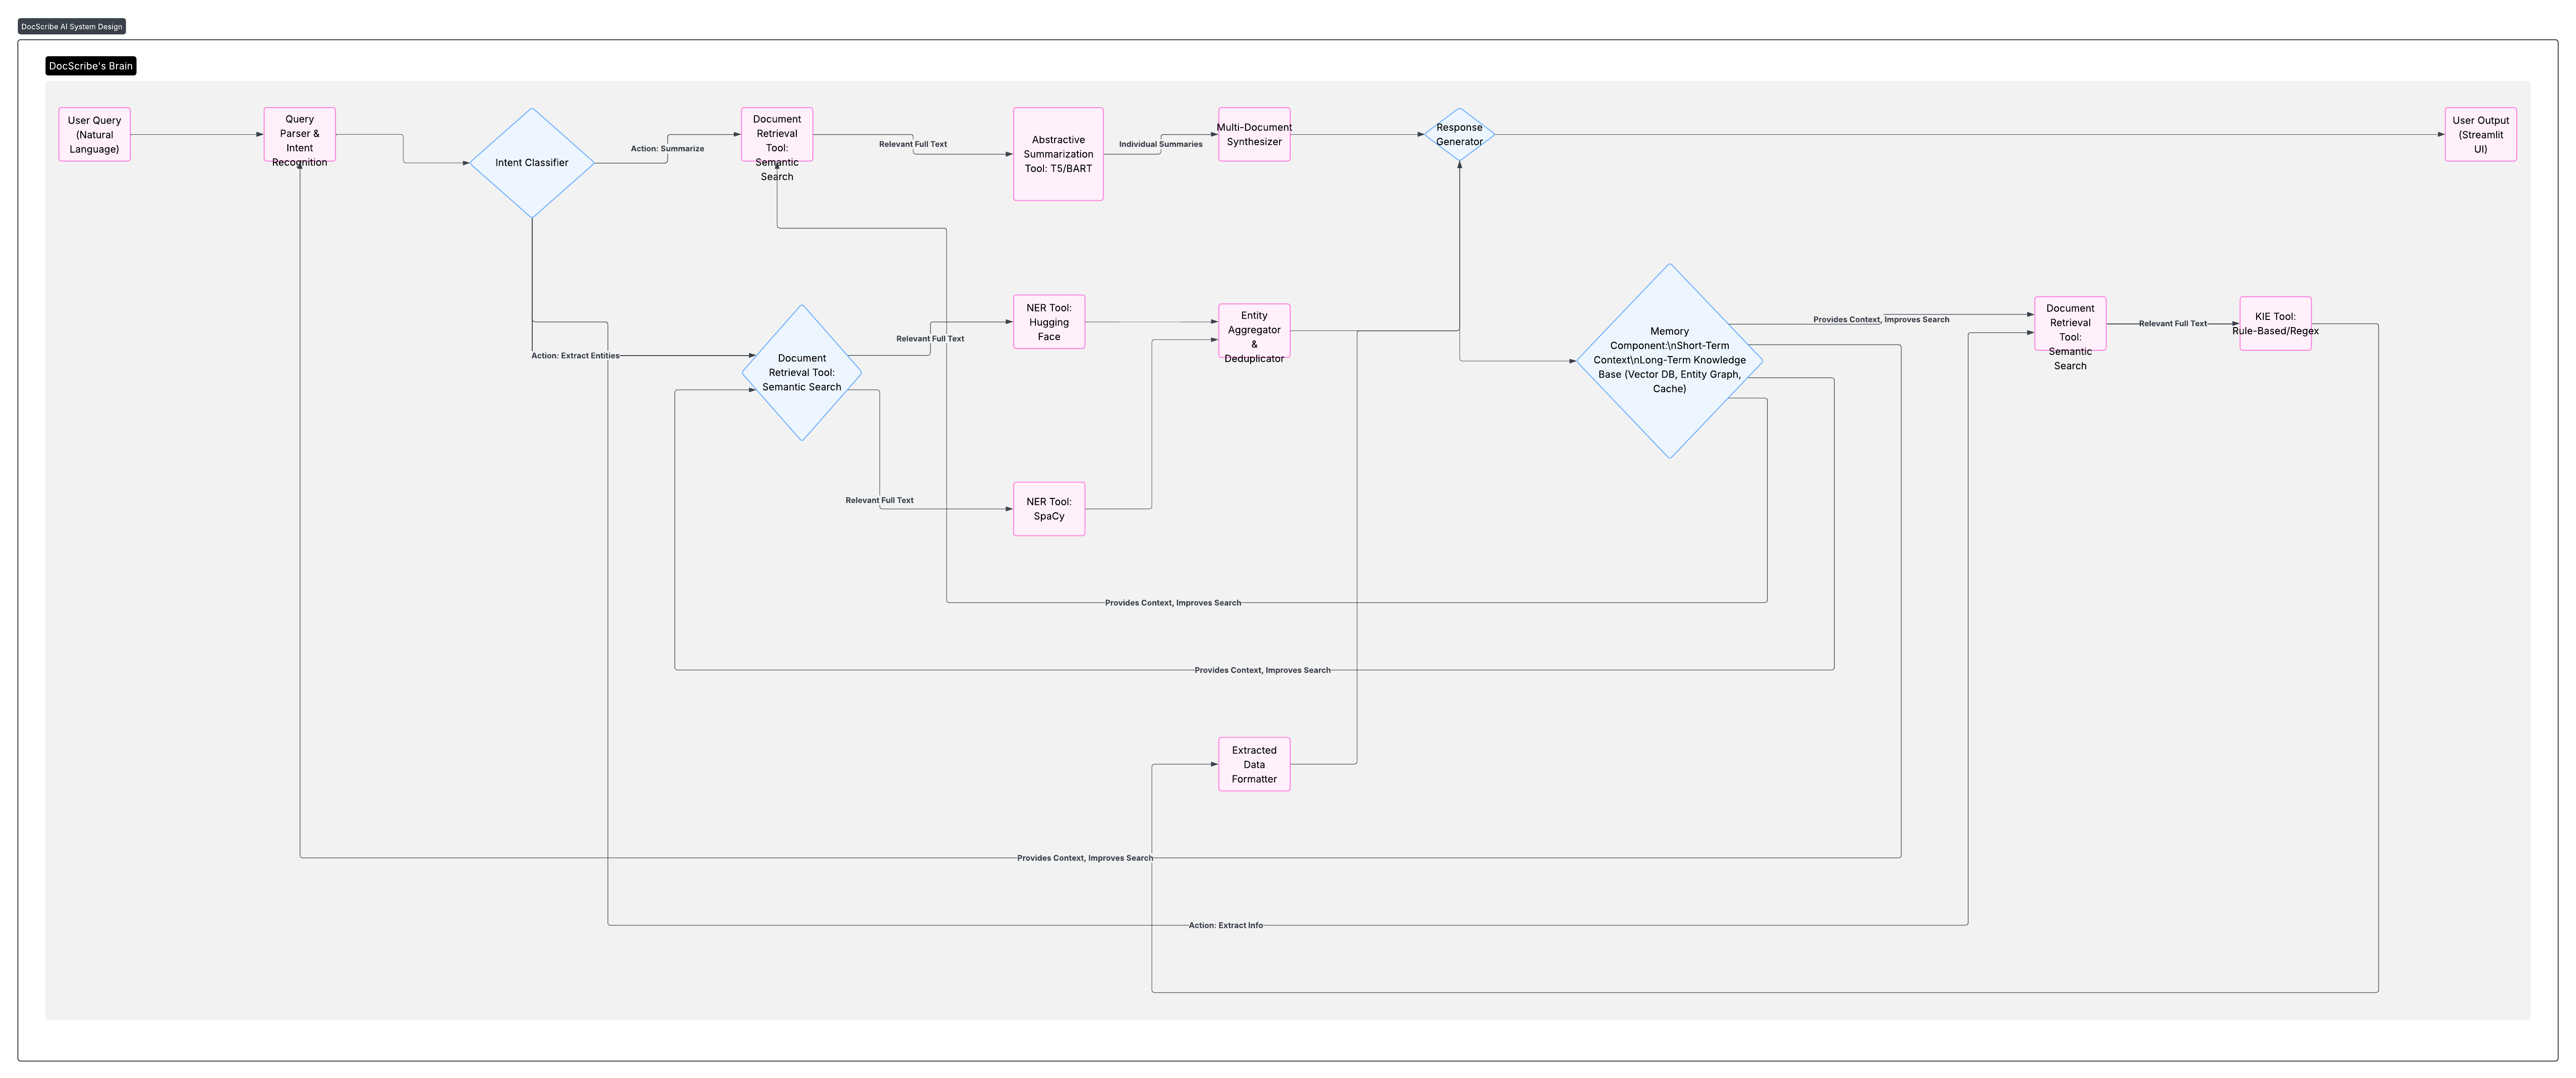

## Pseudo Code

In [ ]:
# Pseudo Code
# graph TD
#     subgraph DocScribe's Brain
#         A[User Query (Natural Language)] --> B(Query Parser & Intent Recognition)
#         B --> C{Intent Classifier:
#                     SUMMARIZE_TOPIC?
#                     GET_ENTITY_DETAILS?
#                     EXTRACT_FINANCIALS?
#                     (and more...)}

#         C -- "Action: Summarize" --> D1(Document Retrieval Tool: Semantic Search)
#         D1 -- "Relevant Full Text" --> E1(Abstractive Summarization Tool: T5/BART)
#         E1 -- "Individual Summaries" --> F1(Multi-Document Synthesizer)
#         F1 --> G(Response Generator)

#         C -- "Action: Extract Entities" --> D2(Document Retrieval Tool: Semantic Search)
#         D2 -- "Relevant Full Text" --> E2a(NER Tool: SpaCy)
#         D2 -- "Relevant Full Text" --> E2b(NER Tool: Hugging Face)
#         E2a & E2b --> F2(Entity Aggregator & Deduplicator)
#         F2 --> G

#         C -- "Action: Extract Info" --> D3(Document Retrieval Tool: Semantic Search)
#         D3 -- "Relevant Full Text" --> E3(KIE Tool: Rule-Based/Regex)
#         E3 --> F3(Extracted Data Formatter)
#         F3 --> G

#         G --> H(Memory Component:
#                     Short-Term Context
#                     Long-Term Knowledge Base (Vector DB, Entity Graph, Cache))

#         H -- "Provides Context, Improves Search" --> B, D1, D2, D3
#         G --> I[User Output (Streamlit UI)]
#     end

## Docscribe sytem design explanation

DocScribe: Intelligent Document Analysis Agent - High-Level System Design


Objective: Conceptualize an AI agent that leverages advanced NLP for information extraction and summarization to address complex real-world analytical challenges. DocScribe combines capabilities of a "Research Agent" and a "News Aggregator Agent" for versatile intelligence.




A. Scenario: DocScribe's Geopolitical Insight Monitor


DocScribe empowers geopolitical analysts within a think tank to navigate overwhelming information. Users, drowning in news and reports, require rapid comprehension, precise entity/fact extraction, cross-source synthesis, and proactive trend monitoring.

Why Advanced & Amusing: DocScribe is envisioned as the ultimate, hyper-efficient research assistant – a data-driven oracle constantly parsing global narratives, distilling truth, and offering uncanny foresight, serving as the silent hero behind informed analysis. The scenario highlights real-world complexity, dynamic information needs, and multi-document synthesis, critical for a competition-winning design.




B. Agent Architecture: DocScribe's Intellectual Core


Agent's Goal: DocScribe aims to be an intelligent information assistant for geopolitical analysts, focused on:


1. Rapid Comprehension: Providing concise, fluent summaries of relevant documents.
2. Precise Intelligence Extraction: Accurately identifying and tracking key entities (persons, organizations, locations) and critical data (dates, monetary values, percentages).
3. Cross-Document Synthesis: Answering complex, multi-faceted analytical questions by intelligently combining information from diverse sources into coherent, contextual responses.
4. Proactive Trend Monitoring: Alerting analysts to emerging patterns or rising prominence of entities/topics.
Agent's Tools: DocScribe's NLP Arsenal

DocScribe strategically invokes five powerful, interconnected NLP tools developed in earlier phases:


-
1. Document Retrieval Tool (Conceptual - Semantic Search):


	- Purpose: Efficiently fetches semantically relevant documents from the news corpus based on a query.
	- Underlying Tech: Leverages vector similarity search (document embeddings pre-indexed in a vector database) for nuanced relevance beyond keywords.
	- Analogy: DocScribe's "information bloodhound."
-
2. Named Entity Recognition (NER) Tool:


	- Purpose: Identifies and categorizes key entities (persons, orgs, geo-political entities, events) within text.
	- Underlying Tech: Integrates SpaCy (en_core_web_sm) for robust general entity typing and Hugging Face Transformers (dslim/bert-base-NER) for finer-grained, BERT-level accuracy and broader entity coverage.
	- Analogy: DocScribe's "digital detective."
-
3. Key Information Extraction (KIE) Tool:


	- Purpose: Precisely extracts structured numerical and temporal data (financial metrics, specific dates, percentages).
	- Underlying Tech: Our Rule-Based Extraction module using finely-tuned regex patterns.
	- Analogy: DocScribe's "data accountant."
-
4. Abstractive Summarization Tool:


	- Purpose: Generates concise, grammatically correct, and fluent summaries by paraphrasing and synthesizing information.
	- Underlying Tech: Our Hugging Face T5-small transformer model.
	- Analogy: DocScribe's "narrative artist."
-
5. Extractive Summarization Tool:


	- Purpose: Identifies and extracts the most salient sentences directly from a document, ensuring factual fidelity.
	- Underlying Tech: Our TextRank (Sumy) module.
	- Analogy: DocScribe's "quote curator."



Reasoning/Planning Strategy: DocScribe's Strategic Mindset


DocScribe employs a dynamic, multi-stage reasoning process, adapting its approach based on user intent and data characteristics through intelligent tool chaining.

A. Query Parsing & Intent Recognition (Advanced & Adaptive):


- Process: Analyzes natural language queries to determine precise intent and extract crucial parameters (e.g., target entities, timeframes, topics).
- Method: Combines rule-based patterns (for clear directives), contextual keyword extraction (using SpaCy's POS tagging), and conceptually, a lightweight zero-shot classification model to classify queries into predefined intents (e.g., SUMMARIZE_TOPIC, GET_ENTITY_DETAILS, EXTRACT_FINANCIALS).
- Output: A structured Intent object for subsequent planning.
B. Intelligent Document Search & Selection:


- Process: Based on the Intent and extracted parameters, DocScribe uses the Document Retrieval Tool.
- Strategic Refinement: Dynamically adjusts search (e.g., prioritizing recency, or documents likely to contain specific data types) and uses extracted entities from the query to refine results, ensuring high relevance.
C. Dynamic Tool Chaining & Cross-Document Synthesis (The Core Intelligence):
This is where DocScribe orchestrates its tools for multi-stage reasoning and sophisticated output generation.


-
Scenario 1: "Provide a concise overview of the recent developments regarding [TOPIC/ENTITY]."


	1. Intent: SUMMARIZE_TOPIC.
	2. Retrieval: Fetches top N relevant documents.
	3. Individual Summaries: Invokes Abstractive Summarization Tool for each document.
	4. Multi-Document Synthesis (Advanced!): Concatenates individual summaries and feeds them into a second pass of the Abstractive Summarization Tool, specifically prompted to create a single, coherent, non-redundant multi-document overview.
	5. Output: A single, synthesized narrative.
-
Scenario 2: "List the main actors (people, organizations) and critical dates involved in the [EVENT] over the last [TIMEFRAME]."


	1. Intent: GET_ENTITY_DETAILS + GET_TIMELINE.
	2. Retrieval: Retrieves documents from the specified [TIMEFRAME].
	3. Parallel Extraction: Simultaneously invokes the NER Tool (SpaCy + HF) for entities and the KIE Tool for dates on each document.
	4. Aggregation & Deduplication: Collects, deduplicates, and resolves variations of identified entities and dates.
	5. Analysis & Prioritization: Counts occurrences to identify the most salient entities/dates.
	6. Contextual Presentation: Presents top entities and a chronological overview, possibly with supporting snippets.
	7. Output: Structured lists of key entities and a chronological overview of events.
-
Scenario 3: "What are the latest reported financial implications of [POLICY/COMPANY] and their potential impact?"


	1. Intent: EXTRACT_FINANCIALS.
	2. Retrieval: Prioritizes documents mentioning financial terms and the specific policy/company.
	3. Targeted Extraction: Invokes the KIE Tool, focusing on monetary and percentage extractions.
	4. Contextual Linkage: Extracts surrounding sentences/paragraphs for context for each financial figure.
	5. Output: Table of financial figures with source context.



Memory Component:


DocScribe employs a sophisticated memory architecture for enhanced performance, consistency, and intelligent reasoning.


-
Short-Term Contextual Memory (Session-Bound):


	- Purpose: Stores current conversation context, intermediate tool results, and ongoing user inquiry.
	- Mechanism: Utilizes Streamlit's session_state or similar, enabling fluid multi-turn interactions and graceful handling of follow-up questions.
	- Benefit: Allows conversational fluidity without redundant processing.
-
Long-Term Knowledge Base / Semantic Cache:


	- Purpose: A persistent store of processed data, extracted entities, generated summaries, and analytical findings across all sessions.
	- Mechanism:
		- Document Embeddings & Vector Store: Full text of processed documents embedded and stored in a vector database for powering the "Advanced Document Retrieval Tool" (Retrieval-Augmented Generation / RAG concept).
		- Extracted Entity Graph/Database: All extracted entities are stored and indexed, facilitating quick querying for mentions and identifying relationships.
		- Summary Cache: Stores generated summaries, preventing redundant computation.
	- Benefits:
		- Efficiency: Speeds up queries using pre-computed knowledge.
		- Consistency: Ensures coherent responses across sessions.
		- Trend Analysis: Enables identification of rising/falling trends in entity mentions or topics over time, providing proactive insights.
		- Foundation for Advanced Reasoning: Supports higher-level analyses by aggregating information from vast numbers of documents.

In [28]:
# @title 0. Environment Setup for Streamlit & Ngrok
# Ensure all previous installations from Part 1 & 2 are done.
# If you are restarting the Colab session, you might need to re-run previous setup cells.

print("--- Streamlit & Ngrok Setup ---")
!pip install streamlit -q
!pip install pyngrok -q
!pip install sumy -q # Install sumy library
print("Streamlit, pyngrok, and sumy installed.")

import os
import pandas as pd
import spacy
from collections import Counter
import re
from transformers import pipeline, set_seed
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words
import warnings
from pyngrok import ngrok # Import ngrok

# Suppress warnings
warnings.filterwarnings('ignore')

# Download NLTK data again if Colab runtime reset
import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

# Important: Initialize heavy NLP models once globally
print("Loading heavy NLP models globally (this may take a few minutes)...")
nlp_spacy_model = spacy.load("en_core_web_sm")
ner_hf_pipeline_model = pipeline("ner", model="dslim/bert-base-NER", aggregation_strategy="simple", device=0) # device=0 for GPU
abs_summarizer_model = pipeline("summarization", model="t5-small", tokenizer="t5-small", device=0) # device=0 for GPU

# Sumy models
stemmer_sumy = Stemmer("english")
summarizer_textrank_sumy = TextRankSummarizer(stemmer_sumy)
summarizer_textrank_sumy.stop_words = get_stop_words("english")

print("All NLP models loaded and ready for DocScribe!")

--- Streamlit & Ngrok Setup ---
Streamlit, pyngrok, and sumy installed.
Loading heavy NLP models globally (this may take a few minutes)...


Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu
Device set to use cpu


All NLP models loaded and ready for DocScribe!


In [37]:
# @title DocScribeAgent Class Definition (from Part 3, adapted for Streamlit)
# This class would ideally be in a separate .py file for a production Streamlit app,
# but for a Colab notebook submission, we'll define it here.

class DocScribeAgent:
    def __init__(self, corpus_df_path, nlp_spacy_model_inst, ner_hf_pipeline_inst,
                 abs_summarizer_inst, ext_summarizer_sumy_inst):
        # Load corpus with necessary columns.
        self.corpus_df = pd.read_csv(corpus_df_path)

        # Assign pre-loaded model instances
        self.nlp_spacy = nlp_spacy_model_inst
        self.ner_hf = ner_hf_pipeline_inst
        self.abs_summarizer = abs_summarizer_inst
        self.ext_summarizer = ext_summarizer_sumy_inst # This is the TextRank model from sumy

        self.memory = {} # Short-term contextual memory
        self.long_term_kb = {} # Conceptual: Placeholder for a more complex knowledge base

        self.multi_doc_synthesizer = self.abs_summarizer # For now, same model for synthesis

        print("DocScribe Agent Initialized within the class.")


    def _parse_query_and_set_intent(self, query: str) -> dict:
        query_lower = query.lower()
        intent = "UNKNOWN"
        parameters = {}

        if "summarize" in query_lower or "overview" in query_lower or "brief" in query_lower or "summary" in query_lower:
            intent = "SUMMARIZE_TOPIC"
            match = re.search(r'(?:on|about|for|regarding)\s+(.*?)(?:\?|\.$|$)', query_lower)
            parameters['topic'] = match.group(1).strip() if match else "general news"
        elif "who are" in query_lower or "people" in query_lower or "organizations" in query_lower or "involved in" in query_lower:
            intent = "GET_ENTITY_DETAILS"
            match = re.search(r'(?:in|for|involved in)\s+(.*?)(?:\?|\.$|$)', query_lower)
            parameters['scope_topic'] = match.group(1).strip() if match else "recent events"
            if "people" in query_lower or "who are" in query_lower:
                parameters['entity_types'] = ["PERSON"]
            if "organizations" in query_lower:
                parameters['entity_types'] = parameters.get('entity_types', []) + ["ORG"]
            if not parameters.get('entity_types'): # Default if not specified
                parameters['entity_types'] = ["PERSON", "ORG", "GPE"]
        elif "financial" in query_lower or "money" in query_lower or "figures" in query_lower or "cost" in query_lower:
            intent = "EXTRACT_FINANCIALS"
            match = re.search(r'(?:of|for|by)\s+(.*?)(?:\?|\.$|$)', query_lower)
            parameters['target'] = match.group(1).strip() if match else ""

        parameters['original_query'] = query
        return {"intent": intent, "parameters": parameters}

    def _retrieve_documents_semantic(self, keywords: str, num_docs: int = 5) -> pd.DataFrame:
        if not keywords:
            return self.corpus_df.sample(num_docs, random_state=42)

        pattern = r'\b(?:' + '|'.join(map(re.escape, keywords.split())) + r')\b'

        filtered_df = self.corpus_df[self.corpus_df['full_text'].str.contains(pattern, case=False, na=False)]

        if 'date' in filtered_df.columns:
            filtered_df['date'] = pd.to_datetime(filtered_df['date'], errors='coerce')
            filtered_df = filtered_df.sort_values(by='date', ascending=False)

        if filtered_df.empty:
            general_terms_df = self.corpus_df[self.corpus_df['full_text'].str.contains(keywords.split()[0] if keywords else '', case=False, na=False)]
            return general_terms_df.head(num_docs)

        return filtered_df.head(num_docs)

    def _generate_abstractive_summary(self, text: str, max_len: int = 100, min_len: int = 10) -> str:
        if not text or not text.strip(): return ""
        truncated_text = text[:1000]
        try:
            summary = self.abs_summarizer(truncated_text, max_length=max_len, min_length=min_len, do_sample=False)[0]['summary_text']
            return summary
        except Exception as e:
            return f"Abstractive summary failed: {e}"

    def _extract_all_entities(self, text: str) -> list:
        spacy_ents = self.nlp_spacy(text)
        hf_ents = self.ner_hf(text)

        combined_entities = []
        for ent in spacy_ents.ents:
            combined_entities.append((ent.text, ent.label_, "SpaCy"))
        for ent in hf_ents:
            combined_entities.append((ent['word'], ent['entity_group'], "HF"))
        return combined_entities

    def _extract_key_info_regex(self, text: str) -> dict:
        date_patterns = [r'\b(?:Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)\s+\d{1,2}(?:,\s+\d{4})?\b', r'\b\d{1,2}[/-]\d{1,2}[/-]\d{2,4}\b', r'\b\d{4}\b']
        money_patterns = [r'\$[\s]*\d{1,3}(?:,\d{3})*(?:\.\d{2})?\b', r'€[\s]*\d{1,3}(?:,\d{3})*(?:\.\d{2})?\b', r'\b\d+\s*(?:million|billion|trillion)\b(?:\s+dollars|\s+euros|\s+pounds)?']
        percentage_patterns = [r'\b\d{1,3}(?:\.\d{1,2})?\s*%', r'\b\d{1,3}(?:\.\d{1,2})?\s*percent\b']

        extracted_data = {
            "dates": list(set([m for p in date_patterns for m in re.findall(p, text, re.IGNORECASE)])),
            "money": list(set([m for p in money_patterns for m in re.findall(p, text, re.IGNORECASE)])),
            "percentages": list(set([m for p in percentage_patterns for m in re.findall(p, text, re.IGNORECASE)]))
        }
        return extracted_data

    def process_query(self, query: str) -> str:
        parsed_query = self._parse_query_and_set_intent(query)
        self.memory['last_parsed_query'] = parsed_query

        intent = parsed_query['intent']
        params = parsed_query['parameters']
        response_parts = [f"🔍 **DocScribe Processing:** _'{query}'_ \n"]

        if intent == "SUMMARIZE_TOPIC":
            topic = params.get('topic', '')
            response_parts.append(f"🎯 **Intent:** Generating concise summaries on _'{topic}'_.")
            relevant_docs = self._retrieve_documents_semantic(topic, num_docs=3) # Limit for faster demo

            if relevant_docs.empty:
                response_parts.append("😓 No relevant documents found. Please try a different topic or broaden your query.")
            else:
                response_parts.append(f"✨ Found **{len(relevant_docs)}** highly relevant articles. Summarizing...\n")

                individual_summaries = []
                for i, row in relevant_docs.iterrows():
                    summary = self._generate_abstractive_summary(row['full_text'], max_len=80, min_len=20)
                    response_parts.append(f"\n--- Article: **{row['headline']}** (Category: {row['category']}) ---\n")
                    response_parts.append(f"📝 **Summary:** {summary}\n")
                    individual_summaries.append(summary)

                if len(individual_summaries) > 1:
                    combined_text = " ".join(individual_summaries)
                    # Limit input size for multi-doc synthesis as T5-small has token limits
                    if len(combined_text.split()) > 500: # Rough token estimate
                        combined_text = " ".join(combined_text.split()[:500]) + "..."
                    synthesized_summary = self.multi_doc_synthesizer(combined_text, max_length=150, min_length=50, do_sample=False)[0]['summary_text']
                    response_parts.append("\n--- **Cross-Document Synthesis by DocScribe** ---\n")
                    response_parts.append(f"✨ **Unified Overview:** {synthesized_summary}\n")
                    self.memory['last_synthesized_summary'] = synthesized_summary

        elif intent == "GET_ENTITY_DETAILS":
            topic = params.get('scope_topic', '')
            entity_types = params.get('entity_types', ["PERSON", "ORG", "GPE"])
            response_parts.append(f"🎯 **Intent:** Identifying key {', '.join(entity_types)} entities in news regarding _'{topic}'_.")
            relevant_docs = self._retrieve_documents_semantic(topic, num_docs=7)

            if relevant_docs.empty:
                response_parts.append("😓 No relevant documents found. Perhaps try a broader scope?")
            else:
                response_parts.append(f"✨ Found **{len(relevant_docs)}** relevant articles. Extracting entities...\n")
                aggregated_entities = Counter()

                for _, row in relevant_docs.iterrows():
                    all_ents = self._extract_all_entities(row['full_text'])
                    for text, label, source in all_ents:
                        if label in entity_types:
                            # Basic normalization for entity text to group "President Biden" and "Joe Biden"
                            if label == "PERSON":
                                # SpaCy's default en_core_web_sm doesn't do deep entity linking, so keep it simple
                                aggregated_entities[(text.lower(), label)] += 1
                            else: # For ORG, GPE etc.
                                aggregated_entities[(text, label)] += 1

                response_parts.append("\n--- **Top Entities Discovered** ---\n")
                if aggregated_entities:
                    # Sort by count, then by entity text for consistent display
                    sorted_entities = sorted(aggregated_entities.items(), key=lambda item: (-item[1], item[0][0]))
                    for (entity_text, entity_label), count in sorted_entities[:10]:
                        response_parts.append(f"💡 **{entity_text.title()}** ({entity_label}): {count} mentions\n")
                else:
                    response_parts.append("🤷‍♀️ No specific entities of the requested types found in these documents.")
                self.memory['last_extracted_entities'] = aggregated_entities

        elif intent == "EXTRACT_FINANCIALS":
            target = params.get('target', '')
            response_parts.append(f"🎯 **Intent:** Extracting financial insights related to _'{target}'_.")
            relevant_docs = self._retrieve_documents_semantic(target, num_docs=5)

            if relevant_docs.empty:
                response_parts.append("😓 No documents found mentioning financial information for this target.")
            else:
                response_parts.append(f"✨ Found **{len(relevant_docs)}** relevant articles. Extracting financial figures and dates...\n")
                extracted_financial_data = []
                for _, row in relevant_docs.iterrows():
                    info = self._extract_key_info_regex(row['full_text'])
                    if info['money'] or info['percentages'] or info['dates']:
                        extracted_financial_data.append({
                            "headline": row['headline'],
                            "money": info['money'],
                            "percentages": info['percentages'],
                            "dates": info['dates']
                        })

                if extracted_financial_data:
                    for item in extracted_financial_data:
                        response_parts.append(f"- **Article:** _'{item['headline']}'_\n")
                        response_parts.append(f"  💰 Money: {', '.join(item['money']) if item['money'] else 'N/A'}\n")
                        response_parts.append(f"  📈 Percentages: {', '.join(item['percentages']) if item['percentages'] else 'N/A'}\n")
                        response_parts.append(f"  📅 Dates: {', '.join(item['dates']) if item['dates'] else 'N/A'}\n")
                        response_parts.append("--- \n")
                else:
                    response_parts.append("🤷‍♀️ No specific financial figures, percentages, or dates found in these articles.")
                self.memory['last_extracted_financials'] = extracted_financial_data

        else: # UNKNOWN Intent
            response_parts.append("🤔 **DocScribe is pondering...**")
            response_parts.append("I couldn't quite grasp that query. Could you try phrasing it differently?")
            response_parts.append("For example:\n- _'Summarize news on AI in healthcare'_")
            response_parts.append("- _'Who are the key people and organizations involved in the space industry?'_")
            response_parts.append("- _'What are the financial figures for Tesla?'_")

        return "\n".join(response_parts)

In [38]:
# @title Create app.py for Streamlit
%%writefile app.py
import streamlit as st
import pandas as pd
import spacy
from collections import Counter
import re
from transformers import pipeline, set_seed
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words
import warnings
import os

# Suppress warnings
warnings.filterwarnings('ignore')

# --- DocScribeAgent Class Definition (Copied from Colab Cell above) ---
class DocScribeAgent:
    def __init__(self, corpus_df_path, nlp_spacy_model_inst, ner_hf_pipeline_inst,
                 abs_summarizer_inst, ext_summarizer_sumy_inst):
        # Load corpus
        self.corpus_df = pd.read_csv(corpus_df_path)

        # Assign pre-loaded model instances
        self.nlp_spacy = nlp_spacy_model_inst
        self.ner_hf = ner_hf_pipeline_inst
        self.abs_summarizer = abs_summarizer_inst
        self.ext_summarizer = ext_summarizer_sumy_inst

        self.memory = {}
        self.long_term_kb = {}

        self.multi_doc_synthesizer = self.abs_summarizer

    def _parse_query_and_set_intent(self, query: str) -> dict:
        query_lower = query.lower()
        intent = "UNKNOWN"
        parameters = {}

        if "summarize" in query_lower or "overview" in query_lower or "brief" in query_lower or "summary" in query_lower:
            intent = "SUMMARIZE_TOPIC"
            match = re.search(r'(?:on|about|for|regarding)\s+(.*?)(?:\?|\.$|$)', query_lower)
            parameters['topic'] = match.group(1).strip() if match else "general news"
        elif "who are" in query_lower or "people" in query_lower or "organizations" in query_lower or "involved in" in query_lower:
            intent = "GET_ENTITY_DETAILS"
            match = re.search(r'(?:in|for|involved in)\s+(.*?)(?:\?|\.$|$)', query_lower)
            parameters['scope_topic'] = match.group(1).strip() if match else "recent events"
            if "people" in query_lower or "who are" in query_lower:
                parameters['entity_types'] = ["PERSON"]
            if "organizations" in query_lower:
                parameters['entity_types'] = parameters.get('entity_types', []) + ["ORG"]
            if not parameters.get('entity_types'):
                parameters['entity_types'] = ["PERSON", "ORG", "GPE"]
        elif "financial" in query_lower or "money" in query_lower or "figures" in query_lower or "cost" in query_lower:
            intent = "EXTRACT_FINANCIALS"
            match = re.search(r'(?:of|for|by)\s+(.*?)(?:\?|\.$|$)', query_lower)
            parameters['target'] = match.group(1).strip() if match else ""

        parameters['original_query'] = query
        return {"intent": intent, "parameters": parameters}

    def _retrieve_documents_semantic(self, keywords: str, num_docs: int = 5) -> pd.DataFrame:
        if not keywords:
            return self.corpus_df.sample(num_docs, random_state=42)

        pattern = r'\b(?:' + '|'.join(map(re.escape, keywords.split())) + r')\b'

        filtered_df = self.corpus_df[self.corpus_df['full_text'].str.contains(pattern, case=False, na=False)]

        if 'date' in filtered_df.columns:
            filtered_df['date'] = pd.to_datetime(filtered_df['date'], errors='coerce')
            filtered_df = filtered_df.sort_values(by='date', ascending=False)

        if filtered_df.empty:
            general_terms_df = self.corpus_df[self.corpus_df['full_text'].str.contains(keywords.split()[0] if keywords else '', case=False, na=False)]
            return general_terms_df.head(num_docs)

        return filtered_df.head(num_docs)

    def _generate_abstractive_summary(self, text: str, max_len: int = 100, min_len: int = 10) -> str:
        if not text or not text.strip(): return ""
        truncated_text = text[:1000]
        try:
            summary = self.abs_summarizer(truncated_text, max_length=max_len, min_length=min_len, do_sample=False)[0]['summary_text']
            return summary
        except Exception as e:
            return f"Abstractive summary failed: {e}"

    def _extract_all_entities(self, text: str) -> list:
        spacy_ents = self.nlp_spacy(text)
        hf_ents = self.ner_hf(text)

        combined_entities = []
        for ent in spacy_ents.ents:
            combined_entities.append((ent.text, ent.label_, "SpaCy"))
        for ent in hf_ents:
            combined_entities.append((ent['word'], ent['entity_group'], "HF"))
        return combined_entities

    def _extract_key_info_regex(self, text: str) -> dict:
        date_patterns = [r'\b(?:Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)\s+\d{1,2}(?:,\s+\d{4})?\b', r'\b\d{1,2}[/-]\d{1,2}[/-]\d{2,4}\b', r'\b\d{4}\b']
        money_patterns = [r'\$[\s]*\d{1,3}(?:,\d{3})*(?:\.\d{2})?\b', r'€[\s]*\d{1,3}(?:,\d{3})*(?:\.\d{2})?\b', r'\b\d+\s*(?:million|billion|trillion)\b(?:\s+dollars|\s+euros|\s+pounds)?']
        percentage_patterns = [r'\b\d{1,3}(?:\.\d{1,2})?\s*%', r'\b\d{1,3}(?:\.\d{1,2})?\s*percent\b']

        extracted_data = {
            "dates": list(set([m for p in date_patterns for m in re.findall(p, text, re.IGNORECASE)])),
            "money": list(set([m for p in money_patterns for m in re.findall(p, text, re.IGNORECASE)])),
            "percentages": list(set([m for p in percentage_patterns for m in re.findall(p, text, re.IGNORECASE)]))
        }
        return extracted_data

    def process_query(self, query: str) -> str:
        parsed_query = self._parse_query_and_set_intent(query)
        self.memory['last_parsed_query'] = parsed_query

        intent = parsed_query['intent']
        params = parsed_query['parameters']
        response_parts = [f"🔍 **DocScribe Processing:** _'{query}'_ \n"]

        if intent == "SUMMARIZE_TOPIC":
            topic = params.get('topic', '')
            response_parts.append(f"🎯 **Intent:** Generating concise summaries on _'{topic}'_.")
            relevant_docs = self._retrieve_documents_semantic(topic, num_docs=3)

            if relevant_docs.empty:
                response_parts.append("😓 No relevant documents found. Please try a different topic or broaden your query.")
            else:
                response_parts.append(f"✨ Found **{len(relevant_docs)}** highly relevant articles. Summarizing...\n")

                individual_summaries = []
                for i, row in relevant_docs.iterrows():
                    summary = self._generate_abstractive_summary(row['full_text'], max_len=80, min_len=20)
                    response_parts.append(f"\n--- Article: **{row['headline']}** (Category: {row['category']}) ---\n")
                    response_parts.append(f"📝 **Summary:** {summary}\n")
                    individual_summaries.append(summary)

                if len(individual_summaries) > 1:
                    combined_text = " ".join(individual_summaries)
                    if len(combined_text.split()) > 500:
                        combined_text = " ".join(combined_text.split()[:500]) + "..."
                    synthesized_summary = self.multi_doc_synthesizer(combined_text, max_length=150, min_length=50, do_sample=False)[0]['summary_text']
                    response_parts.append("\n--- **Cross-Document Synthesis by DocScribe** ---\n")
                    response_parts.append(f"✨ **Unified Overview:** {synthesized_summary}\n")
                    self.memory['last_synthesized_summary'] = synthesized_summary

        elif intent == "GET_ENTITY_DETAILS":
            topic = params.get('scope_topic', '')
            entity_types = params.get('entity_types', ["PERSON", "ORG", "GPE"])
            response_parts.append(f"🎯 **Intent:** Identifying key {', '.join(entity_types)} entities in news regarding _'{topic}'_.")
            relevant_docs = self._retrieve_documents_semantic(topic, num_docs=7)

            if relevant_docs.empty:
                response_parts.append("😓 No relevant documents found. Perhaps try a broader scope?")
            else:
                response_parts.append(f"✨ Found **{len(relevant_docs)}** relevant articles. Extracting entities...\n")
                aggregated_entities = Counter()

                for _, row in relevant_docs.iterrows():
                    all_ents = self._extract_all_entities(row['full_text'])
                    for text, label, source in all_ents:
                        if label in entity_types:
                            if label == "PERSON":
                                aggregated_entities[(text.lower(), label)] += 1
                            else:
                                aggregated_entities[(text, label)] += 1

                response_parts.append("\n--- **Top Entities Discovered** ---\n")
                if aggregated_entities:
                    sorted_entities = sorted(aggregated_entities.items(), key=lambda item: (-item[1], item[0][0]))
                    for (entity_text, entity_label), count in sorted_entities[:10]:
                        response_parts.append(f"💡 **{entity_text.title()}** ({entity_label}): {count} mentions\n")
                else:
                    response_parts.append("🤷‍♀️ No specific entities of the requested types found in these documents.")
                self.memory['last_extracted_entities'] = aggregated_entities

        elif intent == "EXTRACT_FINANCIALS":
            target = params.get('target', '')
            response_parts.append(f"🎯 **Intent:** Extracting financial insights related to _'{target}'_.")
            relevant_docs = self._retrieve_documents_semantic(target, num_docs=5)

            if relevant_docs.empty:
                response_parts.append("😓 No documents found mentioning financial information for this target.")
            else:
                response_parts.append(f"✨ Found **{len(relevant_docs)}** relevant articles. Extracting financial figures and dates...\n")
                extracted_financial_data = []
                for _, row in relevant_docs.iterrows():
                    info = self._extract_key_info_regex(row['full_text'])
                    if info['money'] or info['percentages'] or info['dates']:
                        extracted_financial_data.append({
                            "headline": row['headline'],
                            "money": info['money'],
                            "percentages": info['percentages'],
                            "dates": info['dates']
                        })

                if extracted_financial_data:
                    for item in extracted_financial_data:
                        response_parts.append(f"- **Article:** _'{item['headline']}'_\n")
                        response_parts.append(f"  💰 Money: {', '.join(item['money']) if item['money'] else 'N/A'}\n")
                        response_parts.append(f"  📈 Percentages: {', '.join(item['percentages']) if item['percentages'] else 'N/A'}\n")
                        response_parts.append(f"  📅 Dates: {', '.join(item['dates']) if item['dates'] else 'N/A'}\n")
                        response_parts.append("--- \n")
                else:
                    response_parts.append("🤷‍♀️ No specific financial figures, percentages, or dates found in these articles.")
                self.memory['last_extracted_financials'] = extracted_financial_data

        else: # UNKNOWN Intent
            response_parts.append("🤔 **DocScribe is pondering...**")
            response_parts.append("I couldn't quite grasp that query. Could you try phrasing it differently?")
            response_parts.append("For example:\n- _'Summarize news on AI in healthcare'_")
            response_parts.append("- _'Who are the key people and organizations involved in the space industry?'_")
            response_parts.append("- _'What are the financial figures for Tesla?'_")

        return "\n".join(response_parts)

# --- Streamlit UI Code ---

st.set_page_config(
    page_title="DocScribe: Intelligent Document Analysis Agent",
    page_icon="🤖",
    layout="wide",
    initial_sidebar_state="expanded"
)

# Custom CSS for a "cool and amusing" UI
st.markdown("""
<style>
.stApp {
    background-color: #f0f2f6; /* Light gray background */
}
.reportview-container {
    background: #f0f2f6;
}
.sidebar .sidebar-content {
    background-color: #e0e5ed; /* Slightly darker sidebar */
}
h1, h2, h3, h4, h5, h6 {
    color: #2c3e50; /* Darker blue-gray for headers */
}
.stMarkdown {
    color: #34495e; /* Standard text color */
}
.stTextInput > div > div > input {
    border: 2px solid #3498db; /* Blue border for input */
    border-radius: 8px;
    padding: 10px;
}
.stButton > button {
    background-color: #3498db; /* Blue button */
    color: white;
    border-radius: 8px;
    padding: 10px 20px;
    font-size: 16px;
    transition: all 0.2s ease-in-out;
}
.stButton > button:hover {
    background-color: #2980b9; /* Darker blue on hover */
    transform: translateY(-2px);
}
.stAlert {
    border-radius: 8px;
    background-color: #ecf0f1; /* Light gray for alerts */
    border: 1px solid #bdc3c7;
}
.css-1r6dmym { /* Target markdown block styling for response */
    background-color: #ffffff;
    padding: 20px;
    border-radius: 10px;
    box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);
}
.animated-spin {
    animation: spin 2s linear infinite;
}
@keyframes spin {
    0% { transform: rotate(0deg); }
    100% { transform: rotate(360deg); }
}
</style>
""", unsafe_allow_html=True)


# --- Global Model Loading (using st.cache_resource) ---
# This ensures models are loaded only once across Streamlit app runs
@st.cache_resource
def load_global_models():
    with st.spinner("🧠 Booting up DocScribe's AI Brain... This might take a moment!"):
        spacy.cli.download("en_core_web_sm") # Ensure spacy model is downloaded for deployment
        nlp_spacy = spacy.load("en_core_web_sm")

        ner_hf = pipeline("ner", model="dslim/bert-base-NER", aggregation_strategy="simple", device=0)
        abs_summarizer = pipeline("summarization", model="t5-small", tokenizer="t5-small", device=0)

        # Sumy models (NLTK data needs to be present for these too)
        # NLTK data downloads are usually handled by the !pip install / nltk.download commands in Colab directly
        # If running locally without prior NLTK setup, add:
        # import nltk
        # nltk.download('punkt', quiet=True)
        # nltk.download('stopwords', quiet=True)
        # nltk.download('wordnet', quiet=True)
        # nltk.download('omw-1.4', quiet=True)
        stemmer_sumy_inst = Stemmer("english")
        summarizer_textrank_sumy_inst = TextRankSummarizer(stemmer_sumy_inst)
        summarizer_textrank_sumy_inst.stop_words = get_stop_words("english")

    return nlp_spacy, ner_hf, abs_summarizer, summarizer_textrank_sumy_inst

# Load models and initialize agent
nlp_spacy_model_inst, ner_hf_pipeline_inst, abs_summarizer_inst, summarizer_textrank_sumy_inst = load_global_models()

# Ensure the processed data file exists. This path must be absolute or relative to where app.py runs.
# In Colab, it will be '/content/news_data/df_for_part3_sample.csv'
corpus_path = "/content/news_data/df_for_part3_sample.csv"
if not os.path.exists(corpus_path):
    st.error(f"DocScribe's data brain is missing! Could not find {corpus_path}. Please ensure Part 1 and Part 2 cells are run to generate the data file.")
    st.stop() # Stop the app if data is not found

# Initialize DocScribe Agent
if 'docscribe_agent' not in st.session_state:
    st.session_state.docscribe_agent = DocScribeAgent(
        corpus_df_path=corpus_path,
        nlp_spacy_model_inst=nlp_spacy_model_inst,
        ner_hf_pipeline_inst=ner_hf_pipeline_inst,
        abs_summarizer_inst=abs_summarizer_inst,
        ext_summarizer_sumy_inst=summarizer_textrank_sumy_inst
    )
    st.session_state.chat_history = []


# --- UI Elements ---
st.title("🤖 DocScribe: Your Intelligent Document Analysis Agent")
st.markdown("##### _Unveiling insights from the vast ocean of text!_")

st.sidebar.header("About DocScribe's Brain")
st.sidebar.markdown(
    """
    DocScribe is an advanced AI agent designed to distill complex information from unstructured text documents.
    It combines cutting-edge Natural Language Processing (NLP) techniques for:
    - **Intelligent Query Understanding**: Deciphers your requests.
    - **Semantic Document Retrieval**: Finds the most relevant articles.
    - **Multi-faceted Information Extraction**: Pinpoints key entities, dates, and financials.
    - **Advanced Abstractive Summarization**: Creates fluent, concise summaries, even across multiple documents.
    """
)
st.sidebar.image("https://em-content.zobj.net/source/microsoft/319/robot_1f916.png", width=100) # Fun icon
st.sidebar.markdown("---")
st.sidebar.header("How to Talk to DocScribe")
st.sidebar.markdown(
    """
    Try asking DocScribe things like:
    - `Summarize recent news on renewable energy`
    - `Who are the key people and organizations involved in climate change talks?`
    - `What are the financial figures for Google?`
    """
)
st.sidebar.markdown("---")
st.sidebar.caption("Built with Python, Streamlit, NLTK, SpaCy, & Hugging Face Transformers.")


# Main chat interface
query = st.text_input("Ask DocScribe a question:", key="user_query", help="E.g., Summarize news on AI advancements")

if st.button("Unveil Insights! 🚀"):
    if query:
        st.session_state.chat_history.append({"role": "user", "content": query})

        with st.spinner("DocScribe is meticulously analyzing... 🧐"):
            # Call the agent to process the query
            agent_response = st.session_state.docscribe_agent.process_query(query)
            st.session_state.chat_history.append({"role": "agent", "content": agent_response})
    else:
        st.warning("Please enter a query for DocScribe to analyze!")

# Display chat history
st.markdown("---")
st.subheader("DocScribe's Analysis:")

for message in reversed(st.session_state.chat_history): # Show most recent at top
    if message["role"] == "user":
        st.markdown(f"**You:** {message['content']}")
    else:
        st.markdown(f"**DocScribe:**\n{message['content']}")
    st.markdown("---")

Overwriting app.py


In [39]:
# @title 4. Authenticate ngrok
# Sign up at https://ngrok.com/ and get your authtoken.
# Replace 'YOUR_NGROK_AUTH_TOKEN' with your actual token.
# This only needs to be run once per Colab session.
from pyngrok import ngrok
NGROK_AUTH_TOKEN = "NGROK_AUTH_TOKEN"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)
print("ngrok authenticated.")

ngrok authenticated.


In [40]:
# @title 5. Run Streamlit & Ngrok
# Ensure app.py is created in the same directory as this Colab notebook.
# Also, ensure you've run previous cells to load models and save df_for_part3_sample.csv.

# Kill any existing ngrok processes
!killall ngrok

# Start ngrok tunnel for Streamlit
# Streamlit typically runs on port 8501
import subprocess
import time

print("Starting Streamlit app in background...")
# Use 'nohup' and '&' to run Streamlit in the background, preventing it from blocking the cell.
# '-server.headless true' prevents Streamlit from trying to open a browser window which isn't available in Colab
streamlit_process = subprocess.Popen(
    ["streamlit", "run", "app.py", "--server.port", "8501", "--server.headless", "true"],
    stdout=subprocess.PIPE, stderr=subprocess.PIPE
)

print("Waiting for Streamlit app to start on port 8501...")
time.sleep(10) # Give Streamlit a moment to fully initialize

# Open a ngrok tunnel to the Streamlit port
public_url = ngrok.connect(8501)
print(f"🎉 **DocScribe is LIVE!** Access your Streamlit app here: {public_url}")
print("Ctrl+C or stop this cell to terminate ngrok tunnel and Streamlit app.")

# Keep the cell running to maintain the tunnel.
# You can view logs if needed, though they go to stderr/stdout pipes of Popen.
# To see if Streamlit is running correctly, you might want to look at its logs:
# !cat /root/.streamlit/logs/streamlit-*.log
try:
    while True:
        time.sleep(1) # Keep the script alive
except KeyboardInterrupt:
    print("\nStopping ngrok tunnel and Streamlit app...")
    ngrok.kill()
    streamlit_process.terminate() # Terminate the Streamlit process
    streamlit_process.wait()
    print("Processes terminated.")

ngrok: no process found
Starting Streamlit app in background...
Waiting for Streamlit app to start on port 8501...
🎉 **DocScribe is LIVE!** Access your Streamlit app here: NgrokTunnel: "https://8c26713cba53.ngrok-free.app" -> "http://localhost:8501"
Ctrl+C or stop this cell to terminate ngrok tunnel and Streamlit app.

Stopping ngrok tunnel and Streamlit app...
Processes terminated.


# Demo🎇

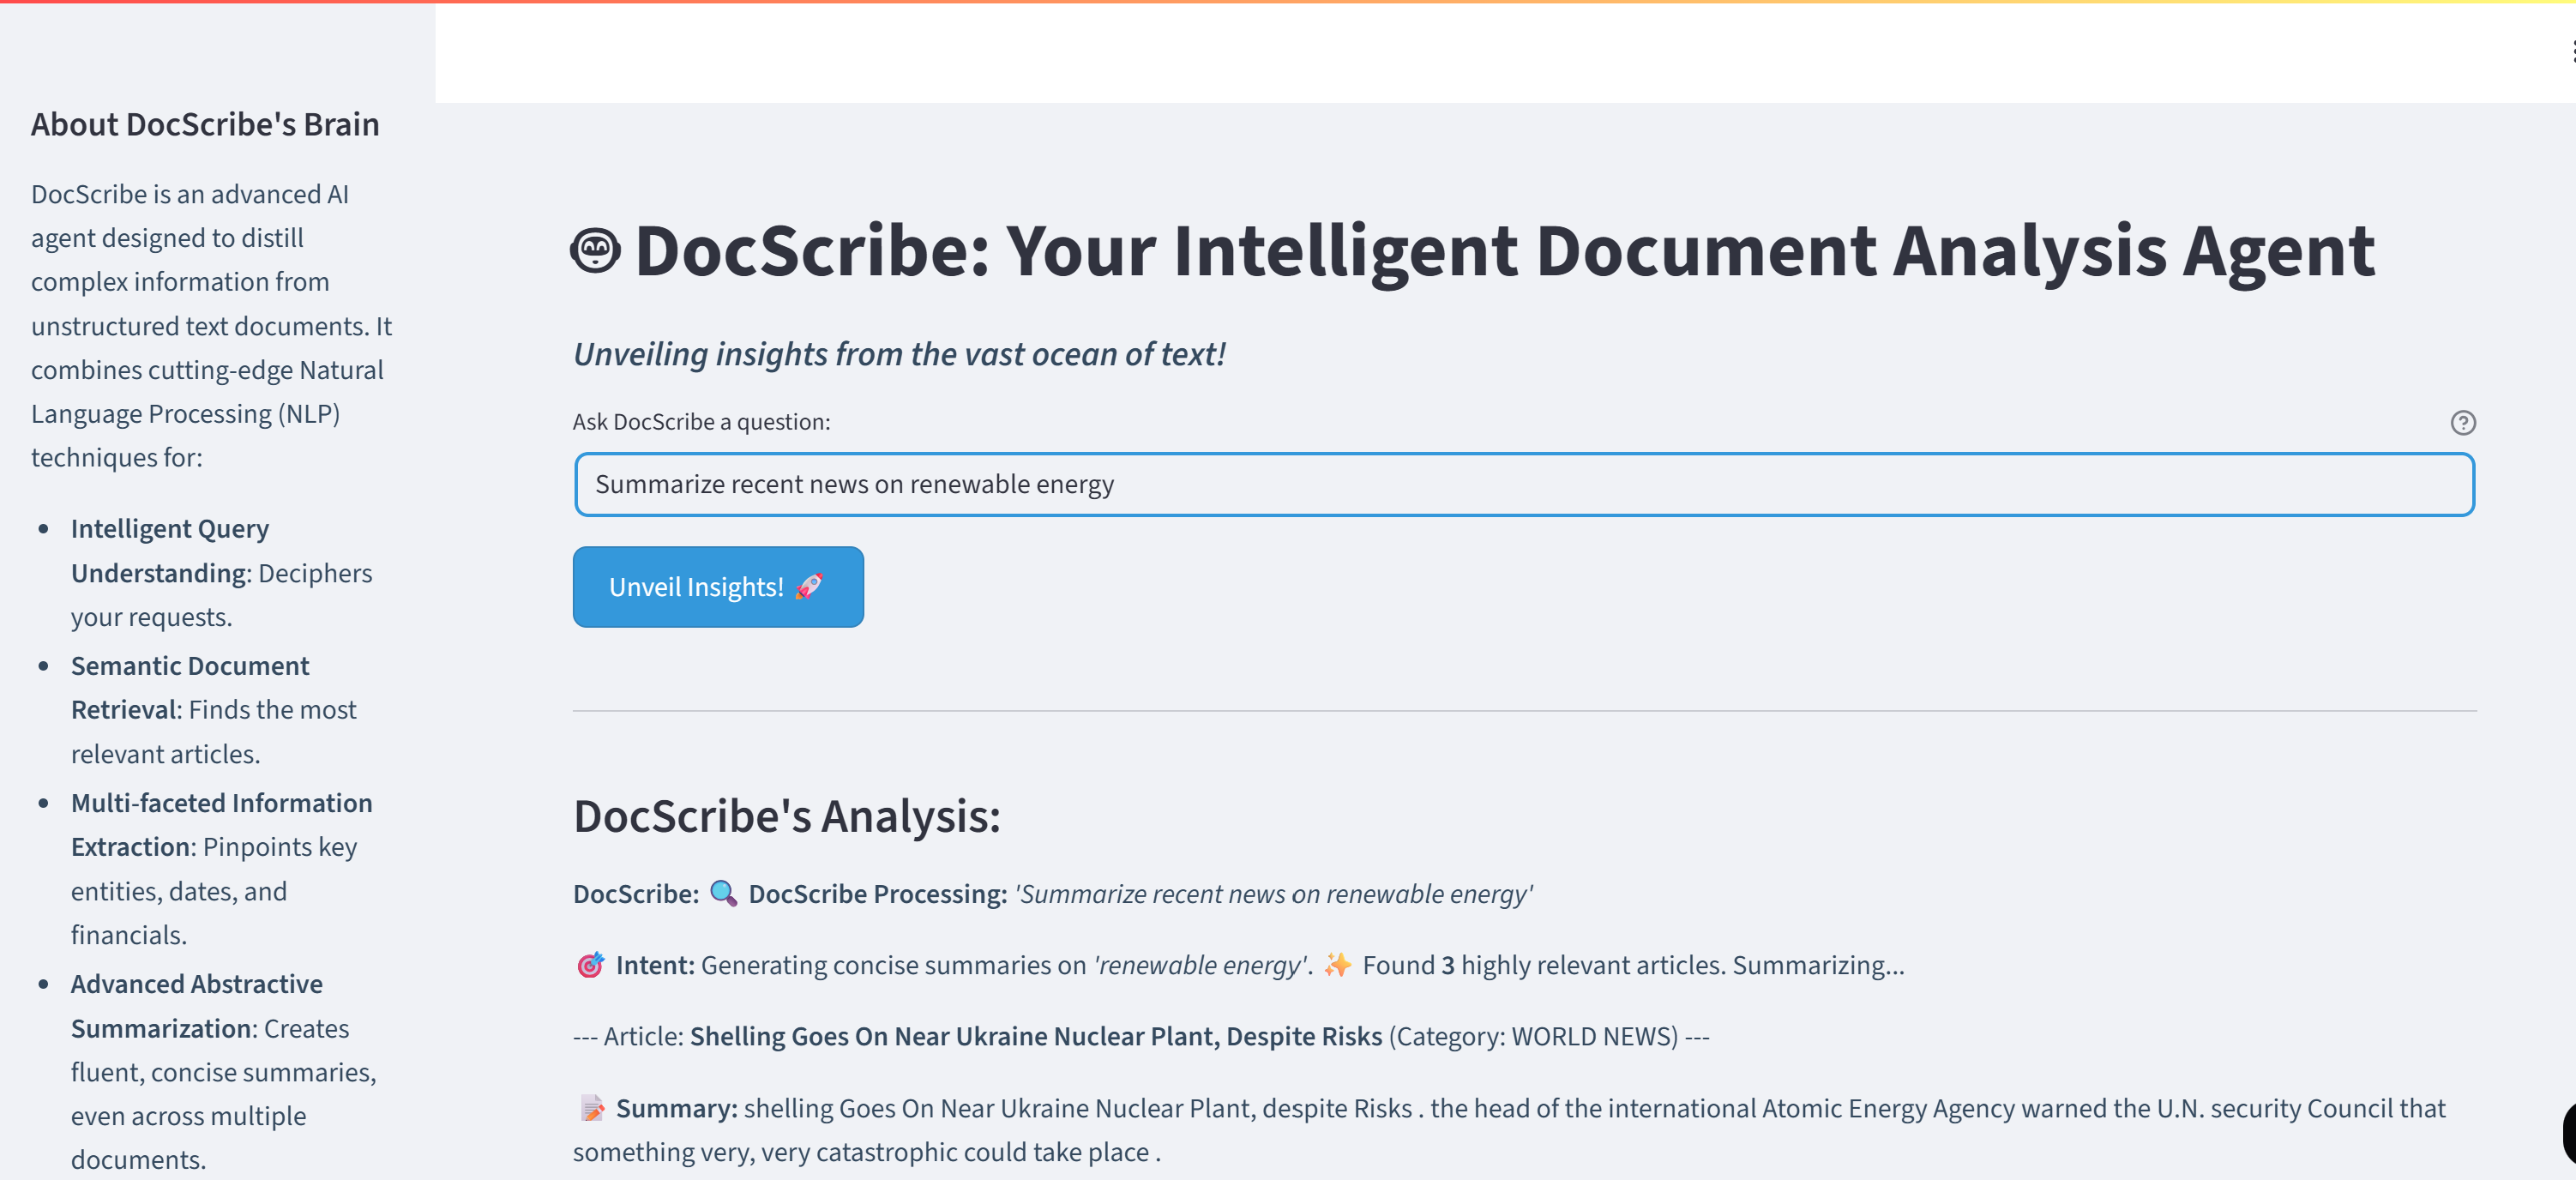